In [1]:
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import synthcity.logger as log
from sklearn.mixture import GaussianMixture as GMM

from datasets import get_dataset

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore")
log.add(sink=sys.stderr, level="DEBUG")

In [2]:
from synthcity.plugins.core.models.time_to_event import \
    get_model_template as get_tte_model_template


class TabularGMM:
    def __init__(self, components: int = 100, random_state: int = 0):
        self.model = GMM(100, covariance_type="full", random_state=random_state)
        self.tte_regressor = get_tte_model_template("survival_function_regression")()

    def fit(self, X, T, E):
        self.model.fit(X)
        self.tte_regressor.fit(X, T, E)

        self.E = E
        self.count = len(X)
        self.columns = X.columns

    def generate(self, count: int = None):
        if count is None:
            count = self.count
        sampled, _ = self.model.sample(count)
        sampled = pd.DataFrame(sampled, columns=self.columns)

        E = self.E.reset_index(drop=True).head(count)

        T = pd.Series(self.tte_regressor.predict_any(sampled, E,))
        return sampled, T, E

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.



In [73]:
from scipy.stats import wasserstein_distance


def ws_distance(real_df, syn_df):
    dist = 0
    cnt = []
    real_cnt = []
    for col in real_df.columns:
        if len(real_df[col].unique()) < 10:
            cnt.append(len(syn_df[col].unique()))
            real_cnt.append(len(real_df[col].unique()))
            dist += (
                np.mean(real_df[col].unique()) - np.mean(syn_df[col].unique())
            ) ** 2 + (np.std(real_df[col]) - np.std(syn_df[col])) ** 2

    return dist, np.mean(cnt), np.mean(real_cnt)

In [74]:
from pathlib import Path

import pandas as pd
from synthcity.plugins.core.models.survival_analysis.metrics import (
    generate_score, print_score)
from synthcity.utils.serialization import (dataframe_hash, load_from_file,
                                           save_to_file)

out_dir = Path("workspace_rebuttal")

models = ["survival_gan", "ctgan", "tvae", "gmm"]
repeat_id = 2

for ref_df in ["aids", "cutract", "maggic", "seer"]:
    df, duration_col, event_col, time_horizons = get_dataset(ref_df)
    df_hash = dataframe_hash(df)

    for idx, model in enumerate(models):
        dist = []
        cnts = []
        real_cnts = []
        for repeat_id in range(3):
            model_bkp = out_dir / f"{df_hash}_{model}_{repeat_id}.bkp"
            syn_df = load_from_file(model_bkp)
            try:
                syn_df = syn_df.dataframe()
            except:
                pass
            ws, cnt, real_cnt = ws_distance(df, syn_df)
            dist.append(ws)
            cnts.append(cnt)
            real_cnts.append(real_cnt)

        print(
            ref_df,
            model,
            print_score(generate_score(dist)),
            print_score(generate_score(cnts)),
            print_score(generate_score(real_cnts)),
        )

aids survival_gan 1.3616 +/- 0.5178 2.5185 +/- 0.1568 2.8889 +/- 0.0
aids ctgan 1.1428 +/- 0.0917 2.6667 +/- 0.0 2.8889 +/- 0.0
aids tvae 4.4452 +/- 0.1254 1.8889 +/- 0.1027 2.8889 +/- 0.0
aids gmm 3.5175 +/- 0.0557 1023.3333 +/- 0.0 2.8889 +/- 0.0
cutract survival_gan 1.9969 +/- 0.696 3.6 +/- 0.1848 4.4 +/- 0.0
cutract ctgan 1.0753 +/- 0.0475 4.0 +/- 0.0 4.4 +/- 0.0
cutract tvae 3.9617 +/- 4.494 3.2 +/- 0.1848 4.4 +/- 0.0
cutract gmm 9.2816 +/- 0.0265 8069.2 +/- 0.0 4.4 +/- 0.0
maggic survival_gan 0.0877 +/- 0.1305 2.0 +/- 0.0 2.0 +/- 0.0
maggic ctgan 0.0384 +/- 0.0036 2.0 +/- 0.0 2.0 +/- 0.0
maggic tvae 0.2659 +/- 0.071 2.0 +/- 0.0 2.0 +/- 0.0
maggic gmm 1.2525 +/- 0.0007 38484.8571 +/- 0.0 2.0 +/- 0.0
seer survival_gan 0.4176 +/- 0.4713 4.4444 +/- 0.3556 5.3333 +/- 0.0
seer ctgan 0.4374 +/- 0.0203 5.0 +/- 0.0 5.3333 +/- 0.0
seer tvae 1.911 +/- 2.0113 4.5556 +/- 0.4705 5.3333 +/- 0.0
seer gmm 2.949 +/- 0.0109 114628.6667 +/- 0.0 5.3333 +/- 0.0


In [75]:
from pathlib import Path

import pandas as pd
from synthcity.utils.serialization import (dataframe_hash, load_from_file,
                                           save_to_file)

out_dir = Path("workspace_rebuttal")

models = ["survival_gan", "ctgan", "tvae", "gmm"]
repeat_id = 2

for ref_df in ["metabric"]:
    df, duration_col, event_col, time_horizons = get_dataset(ref_df)
    df_hash = dataframe_hash(df)

    for idx, model in enumerate(models):
        dist = []
        cnts = []
        real_cnts = []
        for repeat_id in range(3):
            model_bkp = out_dir / f"{df_hash}_{model}_{model}__{repeat_id}.bkp"
            syn_df = load_from_file(model_bkp)
            try:
                syn_df = syn_df.dataframe()
            except:
                pass
            ws, cnt, real_cnt = ws_distance(df, syn_df)
            dist.append(ws)
            cnts.append(cnt)
            real_cnts.append(real_cnt)

        print(
            ref_df,
            model,
            print_score(generate_score(dist)),
            print_score(generate_score(cnts)),
            print_score(generate_score(real_cnts)),
        )

metabric survival_gan 203.4568 +/- 12.3465 1.7465 +/- 0.0225 4.493 +/- 0.0
metabric ctgan 75.4882 +/- 28.5561 2.6573 +/- 0.2104 4.493 +/- 0.0
metabric tvae 202.4928 +/- 30.889 1.7512 +/- 0.0795 4.493 +/- 0.0
metabric gmm 276.0168 +/- 0.4467 1077.6338 +/- 0.0 4.493 +/- 0.0


In [9]:
import string
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from lifelines import KaplanMeierFitter
from sklearn.manifold import TSNE
from synthcity.plugins import Plugins
from synthcity.utils.serialization import (dataframe_hash, load_from_file,
                                           save_to_file)

out_dir = Path("workspace_rebuttal")
fontsize = 14
plt.style.use("seaborn-whitegrid")


def map_models(model):
    return {
        "survival_gan": "SurvivalGAN",
        "adsgan": "AdsGAN",
        "ctgan": "CTGAN",
        "tvae": "TVAE",
        "privbayes": "PrivBayes",
        "nflow": "nFlows",
        "gmm": "GMM",
    }[model]


def plot_km(
    ax,
    title,
    T: pd.Series,
    E: pd.Series,
    syn_T: pd.Series,
    syn_E: pd.Series,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
    syn_label: str = None,
    xaxis_label: str = None,
    yaxis_label: str = None,
    show_title: bool = True,
) -> None:
    gt_kmf = KaplanMeierFitter()
    gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
    ax = gt_kmf.plot(
        ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
    )

    if syn_label is None:
        syn_label = "Synthetic data"

    syn_kmf = KaplanMeierFitter()
    syn_kmf.fit(
        syn_T, syn_E, label=syn_label
    )  # t = Timepoints, Rx: 0=censored, 1=event
    ax = syn_kmf.plot(
        ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
    )
    ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
    if show_title:
        ax.set_xlabel(title, horizontalalignment="center")
    else:
        ax.set_xlabel("Days", horizontalalignment="center")

    if yaxis_label is None:
        yaxis_label = "Temporal fidelity(Kaplan-Meier)"
    ax.set_ylabel(yaxis_label)


def plot_tsne(ax, proj_real: pd.DataFrame, df_syn: pd.DataFrame,) -> None:
    tsne_syn = TSNE(n_components=2, random_state=0)
    proj_syn = pd.DataFrame(tsne_syn.fit_transform(df_syn))

    ax.scatter(x=proj_real[0], y=proj_real[1], s=3, alpha=0.8, label="Real data")
    ax.scatter(x=proj_syn[0], y=proj_syn[1], s=3, alpha=0.8, label="Synthetic data")
    ax.set_ylabel("Covariate diversity(t-SNE)", fontsize=fontsize)


def plot_2d(
    dataset: str,
    models: list,
    individual: bool = False,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    repeat_id: int = 0,
    save: bool = False,
    **kwargs,
):
    df, duration_col, event_col, time_horizons = get_dataset(ref_df)

    df_hash = dataframe_hash(df)

    tsne = TSNE(n_components=2, random_state=0)
    proj_real = pd.DataFrame(tsne.fit_transform(df))

    fig, axs = plt.subplots(2, len(models), figsize=(4 * len(models), 6))

    for idx, model in enumerate(models):
        model_bkp = out_dir / f"{df_hash}_{model}_{repeat_id}.bkp"
        if model_bkp.exists():
            syn_df = load_from_file(model_bkp)
            try:
                syn_df = syn_df.dataframe()
            except:
                pass
        else:
            print(model_bkp, "missing")
            continue

        plot_tsne(axs[0][idx], proj_real, syn_df)
        plot_km(
            axs[1][idx],
            map_models(model),
            df[duration_col],
            df[event_col],
            syn_df[duration_col],
            syn_df[event_col],
        )

    fig.suptitle(f"Dataset: {dataset}", fontsize=16)
    plt.tight_layout()

    if save:
        plt.savefig(f"diagrams/fidelity_grouped_{dataset}.pdf")
        plt.savefig(f"diagrams/fidelity_grouped_{dataset}.png")
    plt.show()

In [ ]:
from pathlib import Path

from adjutorium.utils.metrics import generate_score, print_score
from synthcity.metrics.eval_statistical import (JensenShannonDistance,
                                                MaximumMeanDiscrepancy)
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.serialization import (dataframe_hash, load_from_file,
                                           save_to_file)

out_dir = Path("workspace_rebuttal")
results = {}
for method in ["survival_gan" "gmm"]:
    distances = []

    for ref_df in ["aids", "cutract", "maggic", "seer"]:

        print("=======================")
        print("Evaluate ", ref_df)

        df, duration_col, event_col, time_horizons = get_dataset(ref_df)
        df_hash = dataframe_hash(df)

        gt_dataloader = SurvivalAnalysisDataLoader(
            df,
            target_column=event_col,
            time_to_event_column=duration_col,
            time_horizons=time_horizons,
        )

        local_dist = []

        for seed in range(3):
            model_bkp = out_dir / f"{df_hash}_{method}_{seed}.bkp"
            syn_df = load_from_file(model_bkp)

            syn_dataloader = SurvivalAnalysisDataLoader(
                syn_df,
                target_column=event_col,
                time_to_event_column=duration_col,
                time_horizons=time_horizons,
            )
            score = MaximumMeanDiscrepancy().evaluate(gt_dataloader, syn_dataloader)
            local_dist.append(score["joint"])

        dist_str = print_score(generate_score(local_dist))

        distances.append((ref_df, dist_str))
        results[method] = distances

results

Evaluate  aids
Evaluate  cutract
Evaluate  maggic


In [1]:
methods = ["survival_gan", "ctgan", "gmm"]

for ref_df in ["aids", "cutract", "maggic", "seer"]:
    plot_2d(ref_df, methods, repeat_id=0)

NameError: name 'plot_2d' is not defined

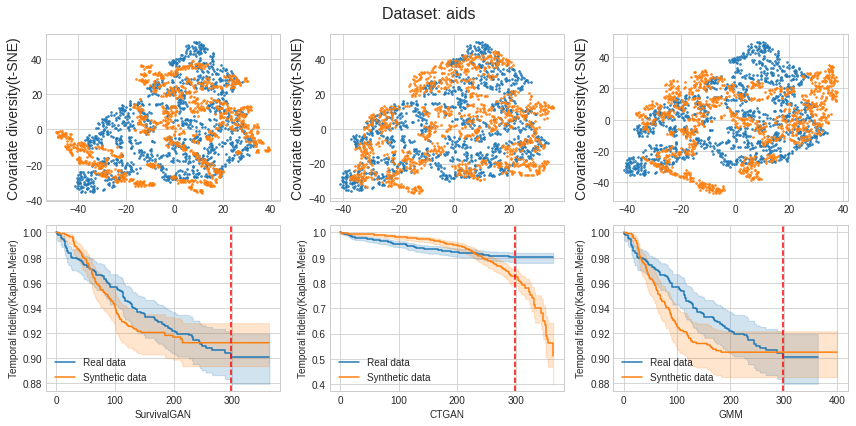

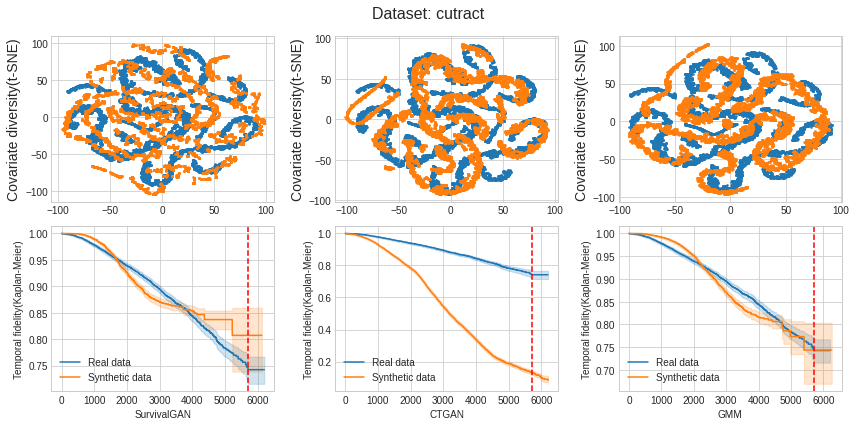

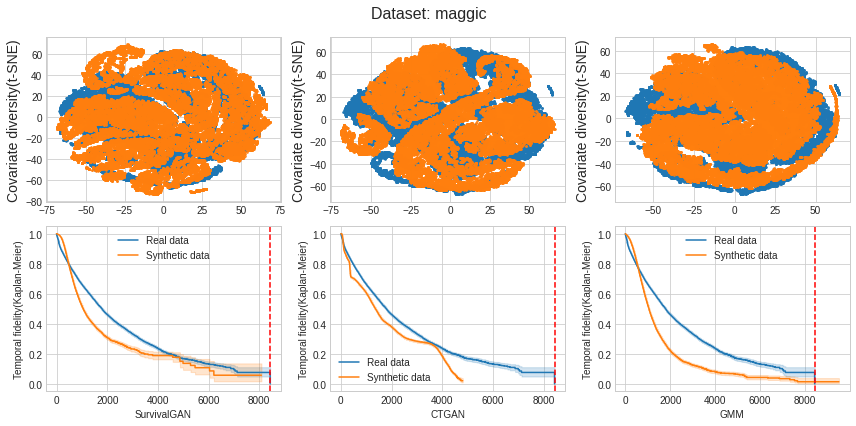

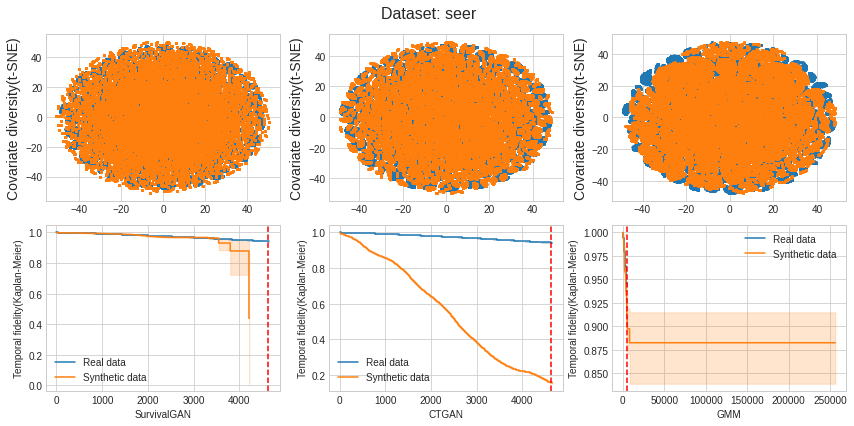

In [11]:
methods = ["survival_gan", "ctgan", "gmm"]

for ref_df in ["aids", "cutract", "maggic", "seer"]:
    plot_2d(ref_df, methods, repeat_id=1)

In [79]:
df, duration_col, event_col, time_horizons = get_dataset("seer")
df_hash = dataframe_hash(df)
model_bkp = out_dir / f"{df_hash}_survival_gan_0.bkp"
syn_df = load_from_file(model_bkp)
syn_df["event"].value_counts()

0    168866
1      3076
Name: event, dtype: int64

AttributeError: 'PosixPath' object has no attribute 'dataframe'